## Biais à prendre en compte
- La quantité de données est très faible, il est donc difficile de généraliser les résultats.
- La date des signalements peut ne pas correspondre à la date de l'incident car les signalements peuvent être faits longtemps après l'incident.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import smopy
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime

# Set the style
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10, 5)

# Set the color
sns.set_palette('Set2')

# Set the Seaborn style
sns.set_style("whitegrid")

# Set the color palette
sns.set_palette('Set2')

# Load the data
df_incidents = pd.read_csv('df_incidents.csv')
df_poi = pd.read_csv('df_poi.csv')
df_incidents = df_incidents[df_incidents['categorie'] == 8]

/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_74184/3256657386.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Paramètres

# Nombre de points d'intérêt à afficher
nb_poi = 10

# Noms des points d'intérêt à afficher ex : 'Crèches et Écoles'
noms_pois = 'Crèches et Écoles'

# Taille de la zone délimitant le nombre d'incidents autour des points d'intérêt
BUFFER_SIZE = 300  # Buffer in meters

# Titre de la carte
title = 'Nombre d\'incidents à moins de 300m des Crèches et Écoles de Montpellier'

# Légende de la carte
legend_incidents = 'Incidents'
legend_poi = 'Points d\'intérêt'

# Titre de la carte interactive
title_interactive = 'Signalements concernant les stationnements gênants autour de Écoles et Crêches dans la ville de Montpellier'

# Légende de la carte interactive
legend_interactive_incidents = 'Incidents'
legend_interactive_poi = 'Points d\'intérêt'

In [12]:
# Creating a column to store the number of incidents
df_poi['Number of incidents'] = 0

# Calculate the distance between each incident and each POI
for i, poi in df_incidents.iterrows():
    for j, incident in df_poi.iterrows():
        distance = geopy.distance.great_circle((poi['latitude'], poi['longitude']),
                                               (incident['latitude'], incident['longitude'])).meters
        if distance < BUFFER_SIZE:
            df_poi['Number of incidents'][j] += 1

# Order the dataframe by the number of incidents in the buffer
df_poi = df_poi.sort_values(by='Number of incidents', ascending=False)
df_poi.head()

/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_74184/2661449636.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_poi['Number of incidents'][j] += 1
/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_74184/266144963

,Unnamed: 0,name,latitude,longitude,Number of incidents
3,585182991,Crèche collective municipale Les Sept Nains,43.614204,3.879547,11
8,595256929,Crèche associative Accroche Cœur,43.617687,3.882115,7
26,1796022006,Les Ateliers d'Arthur,43.612776,3.865531,7
11,607355557,Crèche municipale Edelweiss,43.603467,3.880709,7
36,4539385901,Halte-garderie L'île aux trésors,43.617402,3.878488,6


Lowered zoom level to keep map size reasonable. (z = 12)


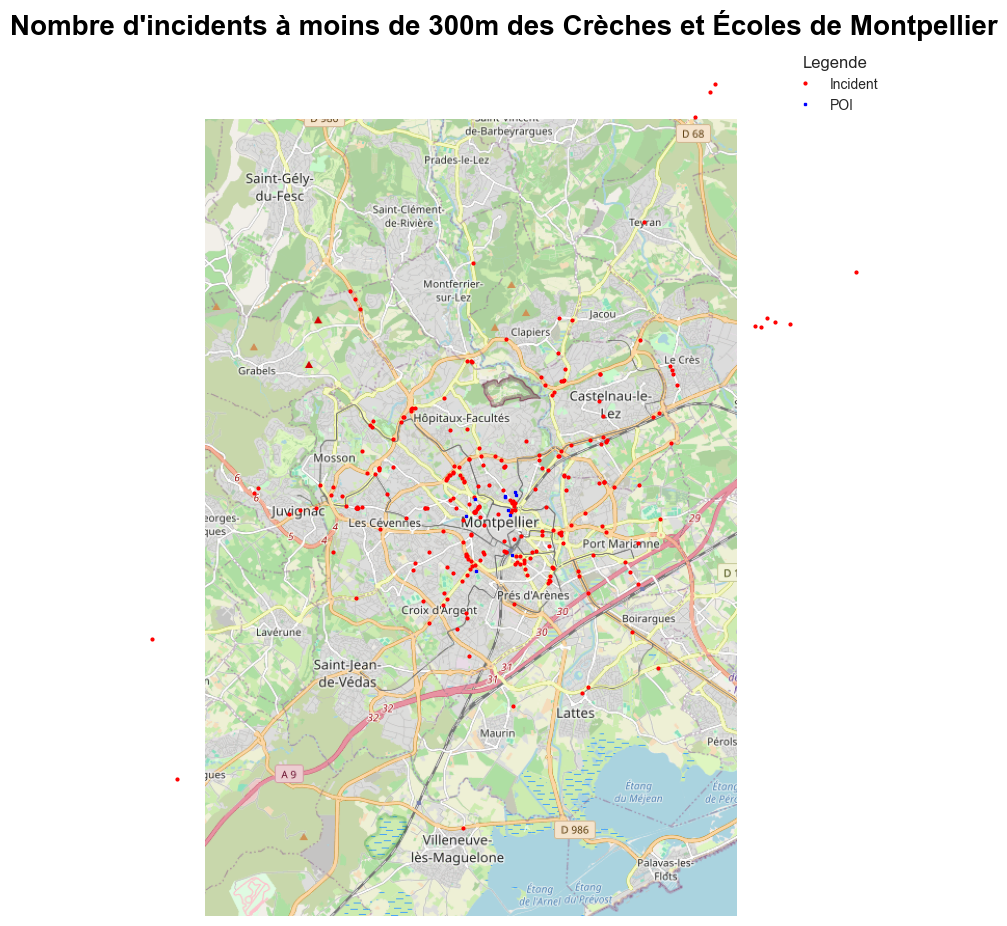

In [4]:
# Define the bounding box based on the center of incidents
lat = df_incidents['latitude'].mean()
lon = df_incidents['longitude'].mean()
delta = 0.05  # Smaller delta for better zooming
box = (lat - delta, lon - delta, lat + delta, lon + delta)

# Create the map with the highest zoom level
map = smopy.Map(box, z=40)  # Using a high zoom level for more detail

# Plot the map
fig, ax = plt.subplots(figsize=(10, 50))  # Horizontal disposition
ax.imshow(map.img)
ax.axis('off')  # Turn off axis graduations

# Function to convert lat/lon to map coordinates and plot the point
def plot_point(lat, lon, color='red', marker='o', label=None):
    x, y = map.to_pixels(lat, lon)
    ax.plot(x, y, marker, color=color, markersize=2, label=label)

# Plot each incident point with a unique label for legend
for i, (lat, lon) in enumerate(df_incidents[['latitude', 'longitude']].values):
    plot_point(lat, lon, label='Incident' if i == 0 else "")

# Plot each POI point with a unique label for legend
for i, (lat, lon, name, number) in enumerate(df_poi[['latitude', 'longitude', 'name', 'Number of incidents']].head(nb_poi).values):
    plot_point(lat, lon, color='blue', marker='s', label='POI' if i == 0 else "")
    x, y = map.to_pixels(lat, lon)
    ax.text(x, y, '', fontsize=10, color='black')

# Add the legend
ax.legend(loc='upper right', fontsize=10 ,title='Legende', title_fontsize='12', shadow=True)

plt.title(title, fontsize=20, fontweight='bold', color='black')
plt.show()



## Carte Intéractive ##

In [5]:
# Create a folium map
m = folium.Map(location=[lat, lon], zoom_start=15)

# Add the incidents as red dots
for i, incident in df_incidents.iterrows():
    folium.Marker([incident['latitude'], incident['longitude']],
                  popup=df_incidents['comment'][i] if not pd.isnull(df_incidents['comment'][i]) else 'Pas de commentaire',
                  icon=folium.Icon(color='red')).add_to(m)  

    
# Add the POI
for i, poi in df_poi.head(nb_poi).iterrows():
    folium.Marker([poi['latitude'], poi['longitude']],
                  popup=df_poi['name'][i] + ' - ' + str(df_poi['Number of incidents'][i]) + f' incidents à moins de {BUFFER_SIZE}m',
                  icon=folium.Icon(color='blue')).add_to(m)


# Add a title
title_html = f'''
             <h3 align="center" style="font-size:20px"><b></b>{title_interactive}</h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))


# Add a legend but not in HTML
legend_html = f'''
             <h3 align="center" style="font-size:20px"><b></b>{legend_interactive_incidents}</h3>
             <h3 align="center" style="font-size:20px"><b></b>{legend_interactive_poi}</h3>
             '''


# Display the map
m

In [6]:
# Create a base map centered around Montpellier
map_montpellier = folium.Map(location=[lat, lon], zoom_start=13)

# Add incidents as a heatmap
incident_locations = df_incidents[['latitude', 'longitude']].values.tolist()
HeatMap(incident_locations).add_to(map_montpellier)

# Add the POI
for i, poi in df_poi.head(nb_poi).iterrows():
    folium.Marker([poi['latitude'], poi['longitude']],
                  popup=df_poi['name'][i] + ' - ' + str(df_poi['Number of incidents'][i]) + f' incidents à moins de {BUFFER_SIZE}m',
                  icon=folium.Icon(color='blue')).add_to(map_montpellier)

# Add a title
title_html = f'''
             <h3 align="center" style="font-size:20px"><b></b>{title}</h3>
             '''
map_montpellier.get_root().html.add_child(folium.Element(title_html))

# Add a legend but not in HTML
legend_html = f'''
             <h3 align="center" style="font-size:20px"><b></b>{legend_incidents}</h3>
             <h3 align="center" style="font-size:20px"><b></b>{legend_poi}</h3>
             '''

# Display the map
map_montpellier

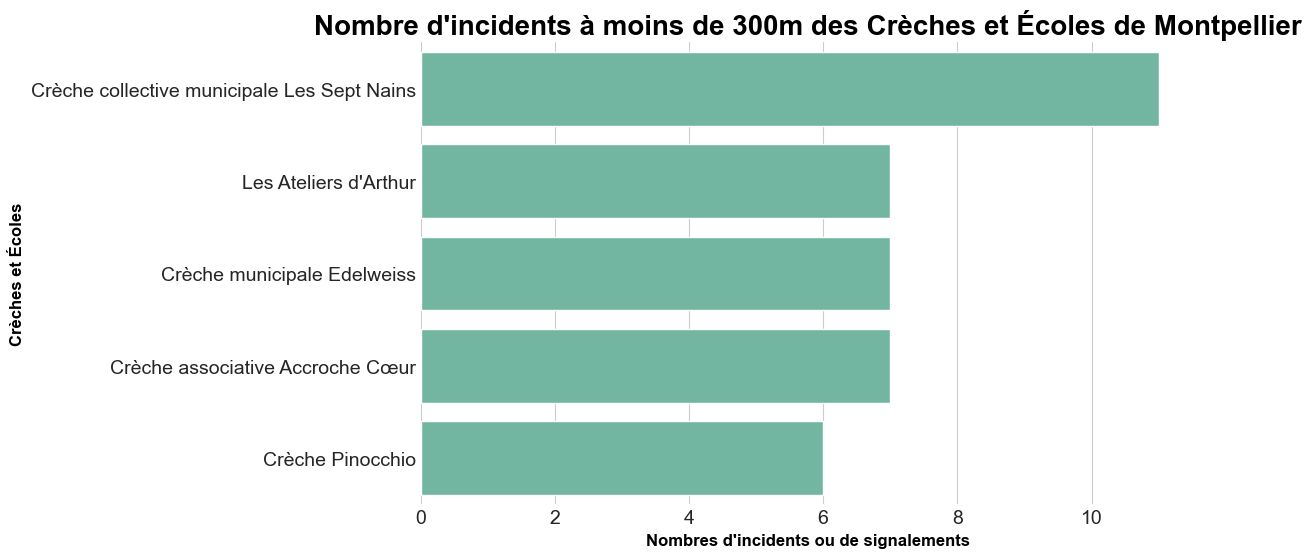

In [7]:

#Plot the number of incidents in the buffer for each POI
titre = None
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of incidents', y='name', data=df_poi.head())
plt.title(label=f'{title}', fontsize=20, fontweight='bold', color='black')
plt.xlabel('Nombres d\'incidents ou de signalements', fontsize=12, fontweight='bold', color='black')
plt.ylabel(noms_pois, fontsize=12, fontweight='bold', color='black')
plt.show()


Trouvons les jours où il y a le plus d'incidents

/var/folders/fn/zw6wxs997ng7zw53fdb1bd4w0000gn/T/ipykernel_74184/2976407608.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap = df_incidents.groupby(['day_of_week', 'hour']).size().unstack()


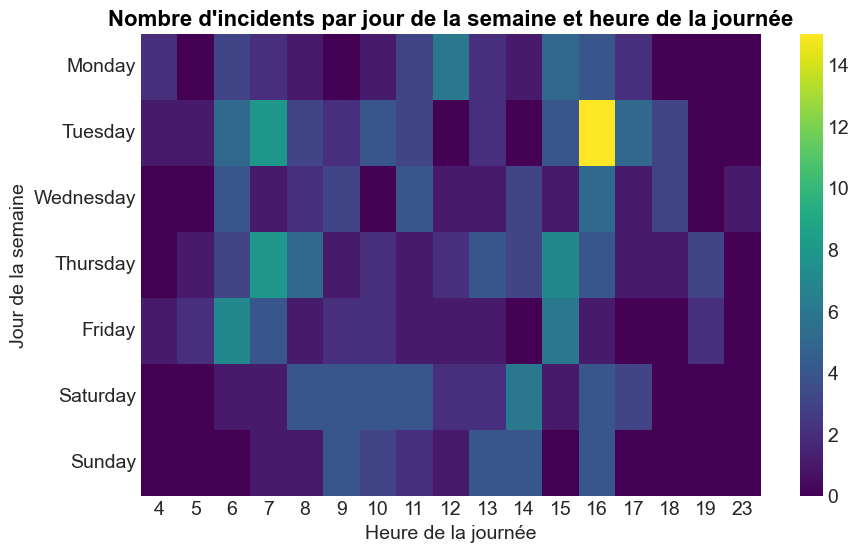

In [8]:
# Convert the date to datetime
df_incidents['time'] = pd.to_datetime(df_incidents['time'])

# Create a column for the day of the week
df_incidents['day_of_week'] = df_incidents['time'].dt.day_name()

# Create a column for the hour of the day
df_incidents['hour'] = df_incidents['time'].dt.hour

# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert the 'day_of_week' column to a categorical type with the specified order
df_incidents['day_of_week'] = pd.Categorical(df_incidents['day_of_week'], categories=days_order, ordered=True)

# Create a heatmap of the number of incidents per day of the week and hour of the day
heatmap = df_incidents.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap, cmap='viridis')
plt.title('Nombre d\'incidents par jour de la semaine et heure de la journée', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Heure de la journée')
plt.ylabel('Jour de la semaine')
plt.show()


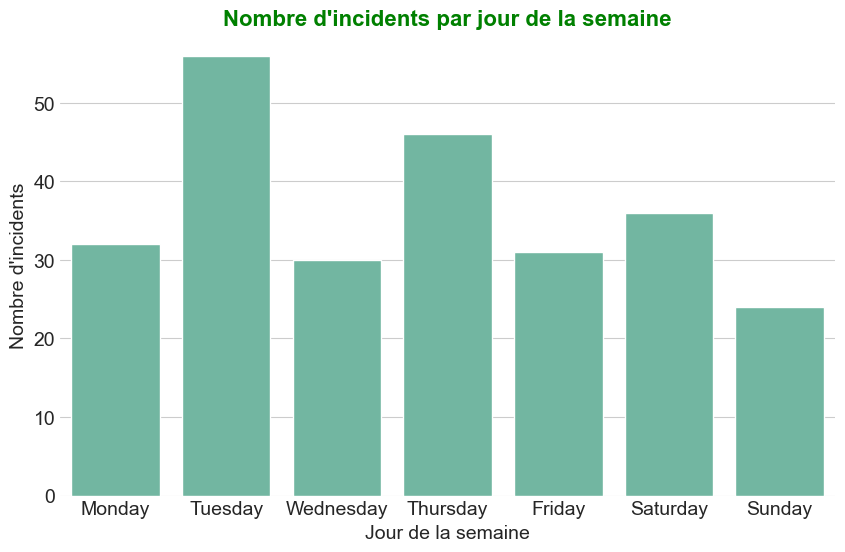

In [9]:
# Create a line plot of the number of incidents per day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=df_incidents, order=days_order)
plt.title('Nombre d\'incidents par jour de la semaine', fontsize=16, fontweight='bold', color='green')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre d\'incidents')
plt.show()

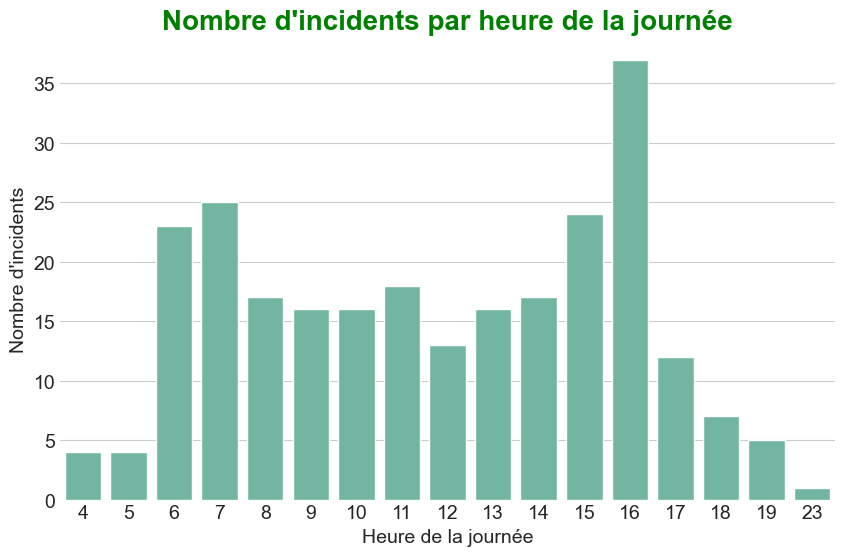

In [10]:
# Create a line plot of the number of incidents per hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df_incidents)
plt.title('Nombre d\'incidents par heure de la journée', fontsize=20, fontweight='bold', color='green')
plt.xlabel('Heure de la journée')
plt.ylabel('Nombre d\'incidents')
plt.show()

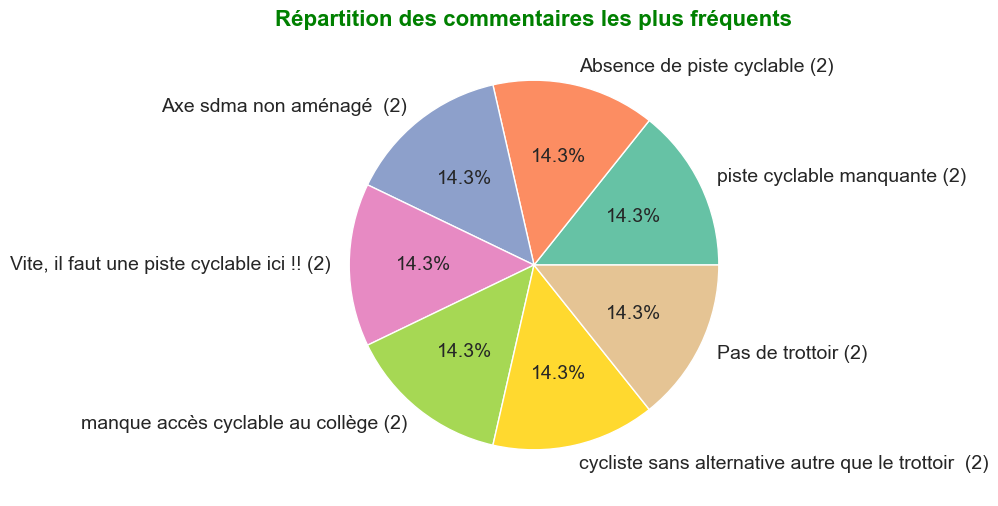

In [11]:
# Finding the most frequent comments with the address of the incident
commentaires = df_incidents['comment'].value_counts()
commentaires = commentaires[commentaires > 1]
commentaires = commentaires.to_frame().reset_index()
commentaires.columns = ['Commentaire', 'Nombre']
commentaires['Adresse'] = None

for i, row in commentaires.iterrows():
    commentaires.at[i, 'Adresse'] = df_incidents[df_incidents['comment'] == row['Commentaire']]['address'].values[0]

# Display the 10 most frequent comments with their addresses
top_commentaires = commentaires.head(10)

# Create labels for the pie chart with comment and count
labels = [f"{row['Commentaire']} ({row['Nombre']})" for _, row in top_commentaires.iterrows()]

# Pie chart of the most frequent comments
plt.figure(figsize=(10, 6))
plt.pie(top_commentaires['Nombre'], labels=labels, autopct='%1.1f%%')
plt.title('Répartition des commentaires les plus fréquents', fontsize=16, fontweight='bold', color='green') 
plt.show()